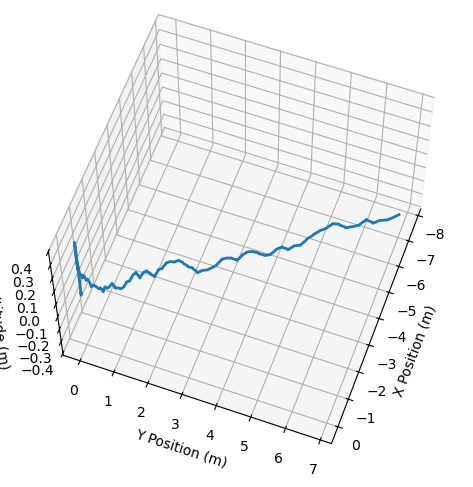

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ahrs.filters import Mahony

# --- UTILITY FUNCTIONS ---
def quaternion_conjugate(q):
    return np.array([q[0], -q[1], -q[2], -q[3]])

def quaternion_multiply(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    return np.array([
        w1*w2 - x1*x2 - y1*y2 - z1*z2,
        w1*x2 + x1*w2 + y1*z2 - z1*y2,
        w1*y2 - x1*z2 + y1*w2 + z1*x2,
        w1*z2 + x1*y2 - y1*x2 + z1*w2
    ])

def quaternion_rotate(q, v):
    """Rotate a 3-vector v by quaternion q (w, x, y, z)."""
    qv = np.concatenate([[0.0], v])
    return quaternion_multiply(
        quaternion_multiply(q, qv),
        quaternion_conjugate(q)
    )[1:]

def pressure_to_altitude(p, p0):
    """Barometric formula: altitude above reference p0."""
    return 44330.0 * (1.0 - (p / p0)**(1/5.255))


# --- USER CONFIGURATION ---
csv_path   = '/Users/benjaminli/Code/Industrial_Project/S_82924/PANORAMIC_RIGHT_all_sensors.csv'
start_time = '2024-05-17 14:05:49'
end_time   = '2024-05-17 14:05:56'

# HPF cutoff and Mahony gains
fc  = 0.01
Kp  = 1.0
Ki  = 0.1

# Precompute HPF constant
tau = 1.0 / (2.0 * np.pi * fc)


# 1) Load & time-filter the CSV
df = pd.read_csv(csv_path)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)
df = df.interpolate(method='linear', limit_direction='both')
df = df.dropna(subset=[
    'GYRO_x','GYRO_y','GYRO_z',
    'HE_ACC_x','HE_ACC_y','HE_ACC_z',
    'MAGNETIC_FIELD_x','MAGNETIC_FIELD_y','MAGNETIC_FIELD_z',
    'PRESSURE'
]).reset_index(drop=True)

mask = (
    (df['timestamp'] >= pd.to_datetime(start_time)) &
    (df['timestamp'] <= pd.to_datetime(end_time))
)
df = df.loc[mask].reset_index(drop=True)
N = len(df)
if N < 2:
    raise ValueError("Not enough data in the specified time window.")


# 2) Prepare storage & filter objects
q       = np.array([1.0, 0.0, 0.0, 0.0])
mahony  = Mahony(Kp=Kp, Ki=Ki, sampleperiod=0.01)

acc_lin     = np.zeros((N, 3))
acc_hp      = np.zeros((N, 3))
vel         = np.zeros((N, 3))
pos         = np.zeros((N, 3))
alt         = np.zeros(N)

# Reference pressure
p0 = df.loc[0, 'PRESSURE']

# --- INITIALIZE using sample 0 ---
row0     = df.loc[0]
gyro0    = np.array([row0.GYRO_x, row0.GYRO_y, row0.GYRO_z]) * np.pi/180.0
acc0_raw = np.array([row0.HE_ACC_x, row0.HE_ACC_y, row0.HE_ACC_z])
mag0     = np.array([
    row0.MAGNETIC_FIELD_x,
    row0.MAGNETIC_FIELD_y,
    row0.MAGNETIC_FIELD_z
])

# (Optional) refine initial quaternion with one Mahony update
q = mahony.updateMARG(q, gyr=gyro0, acc=acc0_raw, mag=mag0)

# Compute first gravity-removed accel and seed HPF
g0           = quaternion_rotate(q, np.array([0.0, 0.0, 9.81]))
a_lin0       = acc0_raw - g0
prev_acc_lin = a_lin0.copy()
acc_hp[0]    = np.zeros(3)  # start HPF at zero

# Set initial states
prev_t   = df.loc[0, 'timestamp']
vel[0]   = np.zeros(3)
pos[0]   = np.zeros(3)
alt[0]   = pressure_to_altitude(row0.PRESSURE, p0)


# 3) Main processing loop from i=1 onward
for i in range(1, N):
    row = df.loc[i]
    t1  = row.timestamp
    dt  = (t1 - prev_t).total_seconds()
    prev_t = t1
    if dt <= 0 or dt > 0.05:
        continue    # skip bad timestamps


    # update Mahony
    mahony.sampleperiod = dt
    gyro  = np.array([row.GYRO_x, row.GYRO_y, row.GYRO_z]) * np.pi/180.0
    accel = np.array([row.HE_ACC_x, row.HE_ACC_y, row.HE_ACC_z])
    mag   = np.array([row.MAGNETIC_FIELD_x,
                      row.MAGNETIC_FIELD_y,
                      row.MAGNETIC_FIELD_z])
    p     = row.PRESSURE

    q = mahony.updateMARG(q, gyr=gyro, acc=accel, mag=mag)

    # gravity compensation
    g_s        = quaternion_rotate(q, np.array([0,0,0]))
    # g_s = quaternion_rotate(quaternion_conjugate(q), [0,0,9.81])

    a_lin      = accel - g_s
    acc_lin[i] = a_lin

    # high-pass filter
    alpha       = tau / (tau + dt)
    acc_hp[i]   = alpha * (acc_hp[i-1] + a_lin - prev_acc_lin)
    prev_acc_lin = a_lin

    # integrate → vel & pos
    # skip the first integrate to drain startup transient
    if i == 1:
        vel[i] = vel[i-1]
        pos[i] = pos[i-1]
    else:
        vel[i] = vel[i-1] + 0.5 * (acc_hp[i] + acc_hp[i-1]) * dt
        pos[i] = pos[i-1] + 0.5 * (vel[i] + vel[i-1]) * dt

    alt[i] = pressure_to_altitude(row.PRESSURE, p0)
    # baro → altitude
    alt[i] = pressure_to_altitude(p, p0)


# 5) Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(pos[:,0], pos[:,1], alt, lw=2)

# Set viewing angles
ax.view_init(elev=60, azim=20)  # Elevation (up/down), Azimuth (around)

ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.set_zlabel('Altitude (m)')
plt.tight_layout()
plt.show()


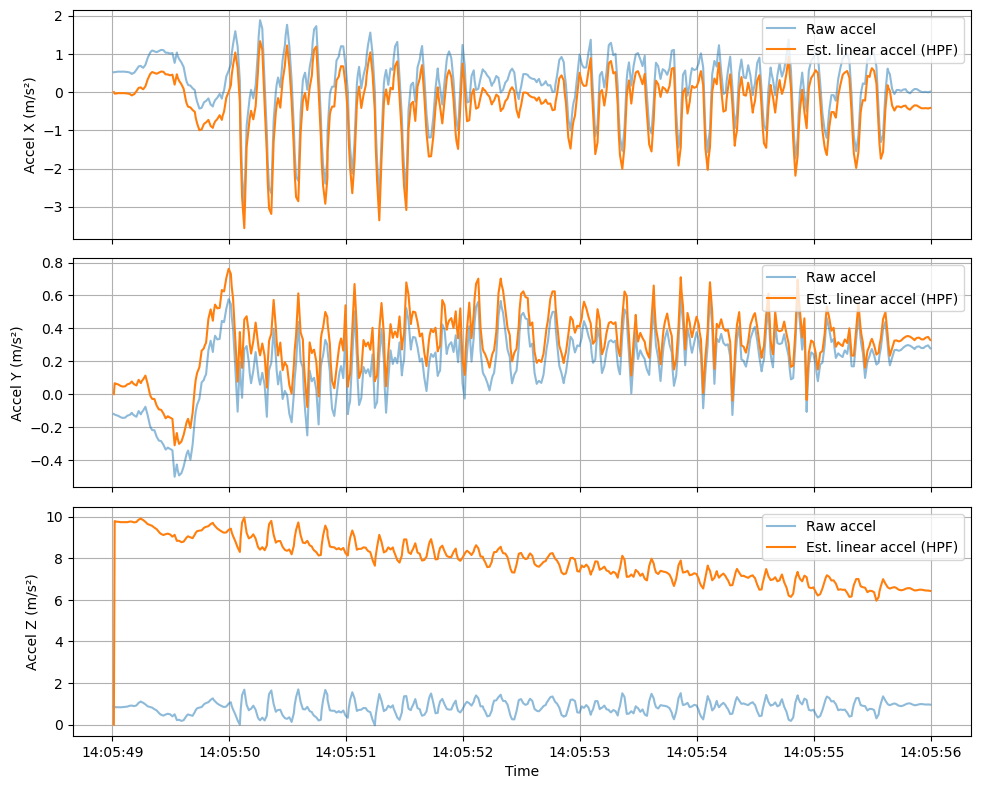

In [36]:
import matplotlib.dates as mdates

# --- Plot original vs. estimated accel ---
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
time = df['timestamp']

axes = ['X', 'Y', 'Z']
raw_cols = ['HE_ACC_x','HE_ACC_y','HE_ACC_z']

for i, ax in enumerate(axs):
    # raw accelerometer
    ax.plot(time, df[raw_cols[i]],   label='Raw accel',    alpha=0.5)
    # high-pass–filtered linear accel (drift-suppressed)
    ax.plot(time, acc_hp[:,i],        label='Est. linear accel (HPF)')
    ax.set_ylabel(f'Accel {axes[i]} (m/s²)')
    ax.legend(loc='upper right')
    ax.grid(True)

# format time axis nicely
axs[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
axs[-1].set_xlabel('Time')
plt.tight_layout()
plt.show()
